# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
import scipy.signal as signal
import random 
import pywt
from sklearn.cross_decomposition import CCA

# Initial Analysis

Here we will perform an initial analysis using PSDA and CCA in order to establish which subjects exhibit the "best" response to the stimulus and which subjects exhibit the "worst" response to the stimulus as well as to what frequencies they respond better and which electrodes provide the best results. With this analysis we will have the information that we need to decide which subject, electrode and frequency to choose for our sequential analysis depending on our needs.

## Power Spectra Density Analysis (PSDA)

In [2]:
low_freq = 5
high_freq = 40
sampling_rate = 250

b, a = signal.butter(4, [low_freq, high_freq], fs=sampling_rate, btype='band')

In [3]:
sampling_rate = 250
data_frequencies, electrodes_names = utils.load_ssvep_additional_info("../TFM-GitHub/Dataset BETA/S1")
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

First we will simply obtain the detected frequency using FFT for all subjects using all electrodes for each trial and stimulus frequency.

In [49]:
psda_results = []
for s in range(1,71):

    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",s)

    subject_result = []

    for electrode in range(64):

        channel_result = []

        for trial in range(4):

            trial_result = []

            for frequency in range(40):

                filtered_eeg = signal.lfilter(b, a, eeg_data[electrode, :, trial, frequency])

                fft_result = np.fft.fft(filtered_eeg)
                freq = np.fft.fftfreq(len(filtered_eeg), d=1/sampling_rate)
                power_spectra = np.abs(fft_result) ** 2

                trial_result.append(np.abs(freq[np.argmax(power_spectra)]))
            
            channel_result.append(trial_result)

        subject_result.append(channel_result)
    
    psda_results.append(subject_result)

Now, let's take a look at the overall detection accuracy for each subject. To do this, we will look for the highest number of detections among all trials using all electrodes. We will create a table where we will se the maximum accuracy for each trial in different columns. We will also add an additional column displaying the overall maximum accuracy.

In [50]:
psda_results = np.array(psda_results)
print(psda_results.shape)

table = np.zeros((70, 5)) # 70 subjects and 5 columns
for s in range(70):
    result = np.zeros(5)
    for tr_idx in range(4):
        for e_idx in range(64):
            count = 0
            for f_idx in range(40):
                if psda_results[s, e_idx, tr_idx, f_idx] % data_frequencies[f_idx] == 0:
                    count += 1
            if result[tr_idx] < count:
                result[tr_idx] = count
    result[-1] = max(result)
    table[s] = result

(70, 64, 4, 40)


In [51]:
def color_higher_eq_five(val):
    if val >= 5:
        return 'color: green'
    else:
        return 'color: red'
    
rows = []
for s in range(70):
    rows.append("Subject "+str(s+1))
df = pd.DataFrame(table, index=rows, columns = ["T1", "T2", "T3", "T4", "MAX"])
styled_df = df.style.applymap(color_higher_eq_five)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_47708/1515966114.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_higher_eq_five)


,T1,T2,T3,T4,MAX
Subject 1,7,7,6,8,8
Subject 2,5,4,6,4,6
Subject 3,7,8,7,8,8
Subject 4,1,1,2,1,2
Subject 5,3,2,4,2,4
Subject 6,5,4,5,5,5
Subject 7,4,4,3,4,4
Subject 8,5,2,4,4,5
Subject 9,7,7,6,7,7
Subject 10,4,5,5,4,5


When we examined the results independently we noticed that only the stimulus frequencies of 8, 9, 10, 11, 12, 13, 14 and 15 were being detected.

In [52]:
detected_frequencies = np.zeros(40)

table = np.zeros((70, 5)) # 70 subjects and 5 columns
for s in range(70):
    result = np.zeros(5)
    for tr_idx in range(4):
        for e_idx in range(64):
            for f_idx in range(40):
                if psda_results[s, e_idx, tr_idx, f_idx] % data_frequencies[f_idx] == 0:
                    detected_frequencies[f_idx] = 1

for i in range(40):
    if detected_frequencies[i] == 1:
        print(str(data_frequencies[i]), "Hz was detected")

9.0 Hz was detected
10.0 Hz was detected
11.0 Hz was detected
12.0 Hz was detected
13.0 Hz was detected
14.0 Hz was detected
15.0 Hz was detected
8.0 Hz was detected


In order to see if we can obtain more information on the quality of the response to the rest of the stimulus frequencies we have modified our approach so that instead of looking for perfect matches between our maximum peak and the stimulus frequency, we will look for the stimulus frequency closest to our detected peak and choose that one as our detected frequency instead.

In [53]:
psda_modifed_results = []
for s in range(1,71):

    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",s)

    subject_result = []

    for electrode in range(64):

        channel_result = []

        for trial in range(4):

            trial_result = []

            for frequency in range(40):

                filtered_eeg = signal.lfilter(b, a, eeg_data[electrode, :, trial, frequency])

                fft_result = np.fft.fft(filtered_eeg)
                freq = np.fft.fftfreq(len(filtered_eeg), d=1/sampling_rate)
                power_spectra = np.abs(fft_result) ** 2
                                
                peak = np.abs(freq[np.argmax(power_spectra)])

                detected_frequency = 0
                min_module = 100000
                for i in range(40):
                    if peak % data_frequencies[i] < min_module:
                        detected_frequency = data_frequencies[i]
                        min_module = peak % detected_frequency
                
                trial_result.append(detected_frequency)
            
            channel_result.append(trial_result)

        subject_result.append(channel_result)
    
    psda_modifed_results.append(subject_result)

In [54]:
psda_modifed_results = np.array(psda_modifed_results)
print(psda_modifed_results.shape)

table = np.zeros((70, 5)) # 70 subjects and 5 columns
for s in range(70):
    result = np.zeros(5)
    for tr_idx in range(4):
        for e_idx in range(64):
            count = 0
            for f_idx in range(40):
                if psda_modifed_results[s, e_idx, tr_idx, f_idx] == data_frequencies[f_idx]:
                    count += 1
            if result[tr_idx] < count:
                result[tr_idx] = count
    result[-1] = max(result)
    table[s] = result

(70, 64, 4, 40)


Here we have the resulting table with the detections per trial. As can be seen, now we have results with more than 8 detections which indicates that now we are detecting frequencies outside of the group mentioned before.

In [55]:
rows = []
for s in range(70):
    rows.append("Subject "+str(s+1))
df = pd.DataFrame(table, index=rows, columns = ["T1", "T2", "T3", "T4", "MAX"])
styled_df = df.style.applymap(color_higher_eq_five)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_47708/4243353774.py:5: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_higher_eq_five)


,T1,T2,T3,T4,MAX
Subject 1,18,16,17,22,22
Subject 2,10,8,9,10,10
Subject 3,17,17,15,18,18
Subject 4,3,4,4,5,5
Subject 5,6,7,7,6,7
Subject 6,15,10,8,9,15
Subject 7,10,7,8,9,10
Subject 8,12,10,10,7,12
Subject 9,15,17,16,18,18
Subject 10,9,15,12,10,15


Now, let's take a look at which frequencies are being detected for each subject. This will give us more information on the quality of the response of each subject for all stimulus frequencies. 

Since showing all of them would take too much space instead we show only one. By chaning the subject number we can see the results for the rest when needed.

The results show that there are some responses closer to the expected results than others. However, this method is not enough to determine the quality of the response for all 40 frequencies. In the next section we will use CCA to try and obtain clearer results.

In [98]:
table = np.zeros(40)
for i in range(40):
    if psda_modifed_results[17, 60, 0, i] == data_frequencies[i]:
        table[i] = 1

In [99]:
print(np.sum(table))

23.0


In [109]:
s = 63
result = np.zeros((4, 40))
for tr_idx in range(4):
    for f_idx in range(40):
        #result[tr_idx][f_idx] = psda_modifed_results[s, e_idx, tr_idx, f_idx]
        if psda_modifed_results[s, 61, tr_idx, f_idx] == data_frequencies[f_idx]:
            result[tr_idx][f_idx] = 1

In [134]:
# Bar plot
freqs_bars = np.zeros(40)
for s in range(70):
    for tr_idx in range(4):
        for f_idx in range(40):
            #result[tr_idx][f_idx] = psda_modifed_results[s, e_idx, tr_idx, f_idx]
            if psda_modifed_results[s, 61, tr_idx, f_idx] == data_frequencies[f_idx]:
                freqs_bars[f_idx] += 1

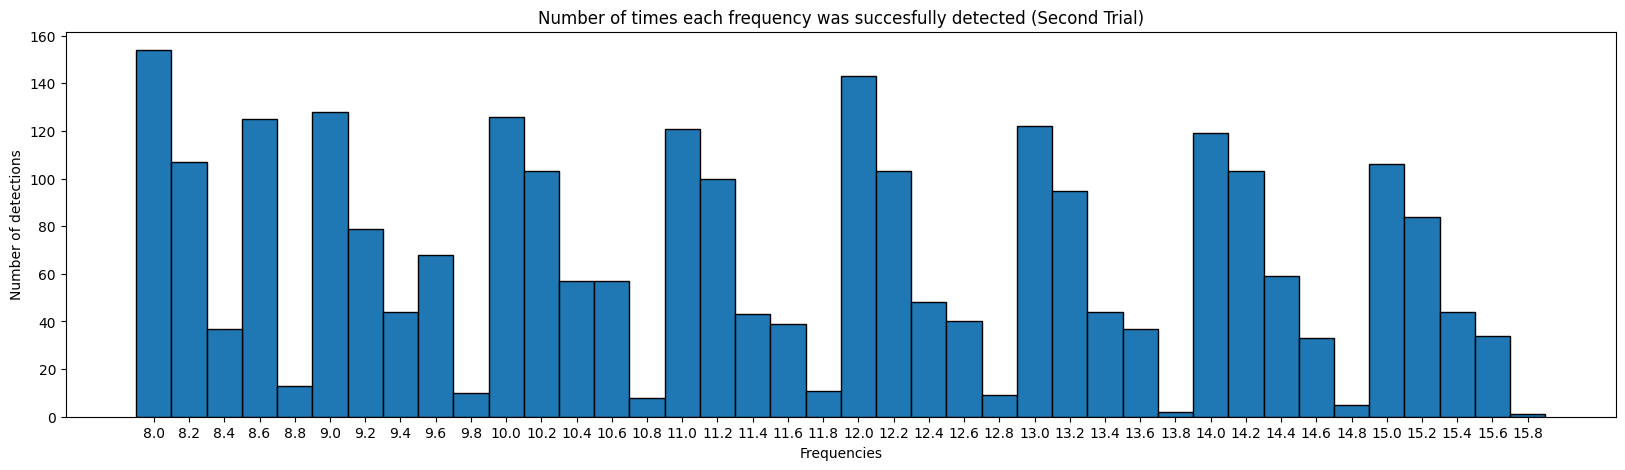

In [135]:
# Create bar plot
plt.figure(figsize=(20,5))
plt.bar(data_frequencies, freqs_bars, width=0.2, edgecolor="black")

# Add labels and title
plt.xlabel('Frequencies')
plt.xticks(data_frequencies)
plt.ylabel('Number of detections')
plt.title('Number of times each frequency was succesfully detected (Second Trial)')

# Show the plot
plt.show()

In [110]:
df = pd.DataFrame(result, index=["T1", "T2", "T3", "T4"], columns = data_frequencies)
styled_df = df.style.applymap(utils.color_numbers_true_false)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_47708/1495816638.py:2: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(utils.color_numbers_true_false)


,8.600000,8.800000,9.000000,9.200000,9.400000,9.600000,9.800000,10.000000,10.200000,10.400000,10.600000,10.800000,11.000000,11.200000,11.400000,11.600000,11.800000,12.000000,12.200000,12.400000,12.600000,12.800000,13.000000,13.200000,13.400000,13.600000,13.800000,14.000000,14.200000,14.400000,14.600000,14.800000,15.000000,15.200000,15.400000,15.600000,15.800000,8.000000,8.200000,8.400000
T1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
T2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
for tr in range(4):
    detected = []
    non_detected = []
    for f in range(40):
        if result[tr][f] == 1:
            detected.append(data_frequencies[f])
        else:
            non_detected.append(data_frequencies[f])
    print("Detected: ", detected)
    print("Non detected: ", non_detected)

Detected:  [11.0, 11.2, 14.200000000000001]
Non detected:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.4, 14.600000000000001, 14.8, 15.0, 15.200000000000001, 15.4, 15.600000000000001, 15.8, 8.0, 8.2, 8.4]
Detected:  [12.2]
Non detected:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.200000000000001, 14.4, 14.600000000000001, 14.8, 15.0, 15.200000000000001, 15.4, 15.600000000000001, 15.8, 8.0, 8.2, 8.4]
Detected:  [12.0]
Non detected:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.2, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.200000000000

## CCA

In [4]:
def find_correlation(data, reference_signals, data_frequencies):
    cca = CCA(n_components=1)
    max_correlation = -np.inf
    most_correlated_frequency = None
    
    for i, ref_signal_set in enumerate(reference_signals):
        X = np.array(ref_signal_set).reshape(-1, 12)  # Reshape reference signals
        Y = data.T  # Transpose EEG data if necessary
        
        cca.fit(X, Y)
        x_scores, y_scores = cca.transform(X, Y)
        correlation = np.corrcoef(x_scores[:, 0], y_scores[:, 0])[0, 1]
        
        if correlation > max_correlation:
            max_correlation = correlation
            most_correlated_frequency = i
    
    return data_frequencies[most_correlated_frequency], max_correlation

In [7]:


electrode_idx = 61 #Electrode Oz

cca_results = np.ones((70, 4, 40)) * -1

for subject in range(1,71):
    
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)

    duration = eeg_data.shape[1]/sampling_rate
    ref_signals = []
    for i in range(40):
        aux = np.array(utils.generate_ref_signal(data_frequencies[i], sampling_rate, duration, 6, 0))
        ref_signals.append(aux)
    ref_signals = np.array(ref_signals)

    for trial_idx in range(4):

        for freq_idx in range(40):

            filtered_eeg = signal.lfilter(b, a, eeg_data[electrode_idx, : , trial_idx, freq_idx])

            prediction, _ = find_correlation(filtered_eeg, ref_signals, data_frequencies)
            cca_results[subject-1, trial_idx, freq_idx] = prediction



In [13]:
table_cca = np.zeros((70, 5))

for subject in range(70):
    for trial_index in range(4):
        for freq_index in range(40):
            if cca_results[subject, trial_index, freq_index] == data_frequencies[freq_index]:
                table_cca[subject, trial_index] += 1

    table_cca[subject, 0] = table_cca[subject, 0]*100/40
    table_cca[subject, 1] = table_cca[subject, 1]*100/40
    table_cca[subject, 2] = table_cca[subject, 2]*100/40
    table_cca[subject, 3] = table_cca[subject, 3]*100/40
    table_cca[subject, 4] = max(max(table_cca[subject, 0], table_cca[subject, 1]), max(table_cca[subject, 2], table_cca[subject, 3]))

In [14]:
def color_cca(val):
    if val == 100:
        return 'color: blue'
    elif val >= 75:
        return 'color: green'
    elif val >= 50:
        return 'color: yellow'
    elif val >= 25:
        return 'color: orange'
    else:
        return 'color: red'
    
rows = []
for s in range(70):
    rows.append("Subject "+str(s+1))
df = pd.DataFrame(table_cca, index=rows, columns = ["T1", "T2", "T3", "T4", "MAX"])
styled_df = df.style.applymap(color_cca)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_938/3961478790.py:17: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_cca)


,T1,T2,T3,T4,MAX
Subject 1,82,82,85,98,98
Subject 2,30,28,15,28,30
Subject 3,90,80,85,88,90
Subject 4,22,22,30,22,30
Subject 5,25,15,15,10,25
Subject 6,48,30,32,35,48
Subject 7,15,22,25,18,25
Subject 8,42,40,42,58,58
Subject 9,82,82,72,72,82
Subject 10,60,72,68,55,72


# Sequential Analysis

## Spectrogram parameters

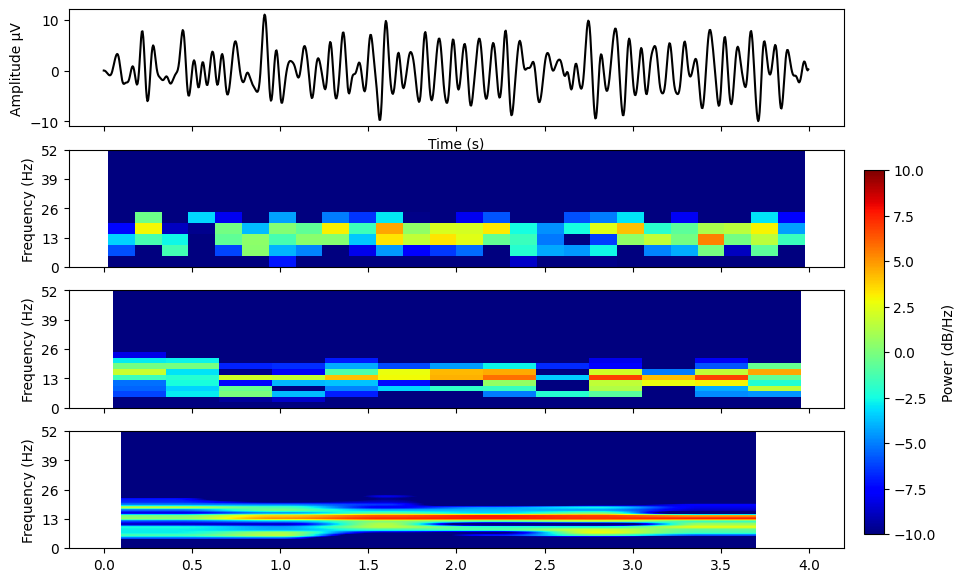

In [97]:
eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",23)
t = np.arange(0, 1000/sampling_rate, 1/sampling_rate)

f_idx = 22
f_value = data_frequencies[f_idx]

# Define the parameters for the spectrogram
fs = sampling_rate  # Sampling frequency
data = eeg_data[61, :, 0, f_idx]
filtered_data = signal.lfilter(b, a, data)

# Compute and plot the spectrogram
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 7), sharex=True)

# Plot the first plot (ax1) with the same time range as the spectrograms
ax1.plot(t, filtered_data, 'k') 
ax1.set_ylabel("Amplitude " + '\u03BC' + "V")
ax1.set_xlabel("Time (s)")
ax1.set_xlim(0, 4) 

frequency_range = (0, 50)

# Set vmin and vmax for the spectrograms to cover the entire range of the data
vmin = -10
vmax = 10

window_lengths = [50, 100, 200]  # Length of the window for computing the spectrogram
overlap = [int(x / 4) for x in window_lengths]  # Overlap between consecutive windows

# Plot spectrograms with limited frequency range
Pxx, freqs, bins, im = ax2.specgram(filtered_data, NFFT=window_lengths[0], Fs=fs, noverlap=overlap[0], cmap='jet', vmin=vmin, vmax=vmax)
#ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_ylim(frequency_range)
ax2.set_yticks([0, f_value, f_value * 2, f_value * 3, f_value * 4])
ax2.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
ax2.set_xlim(0, 4) 

Pxx, freqs, bins, im = ax3.specgram(filtered_data, NFFT=window_lengths[1], Fs=fs, noverlap=overlap[1], cmap='jet', vmin=vmin, vmax=vmax)
#ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_ylim(frequency_range)
ax3.set_yticks([0, f_value, f_value * 2, f_value * 3, f_value * 4])

Pxx, freqs, bins, im = ax4.specgram(filtered_data, NFFT=window_lengths[2], Fs=fs, noverlap=overlap[2], cmap='jet', vmin=vmin, vmax=vmax)
#ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_ylim(frequency_range)
ax4.set_yticks([0, f_value, f_value * 2, f_value * 3, f_value * 4])
#ax4.axhline(13, color="black", linewidth=2)

# Create colorbars next to the first plot
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.52])
cbar = plt.colorbar(im, cax=cbar_ax, label='Power (dB/Hz)')

plt.show()

## PyWavelets 

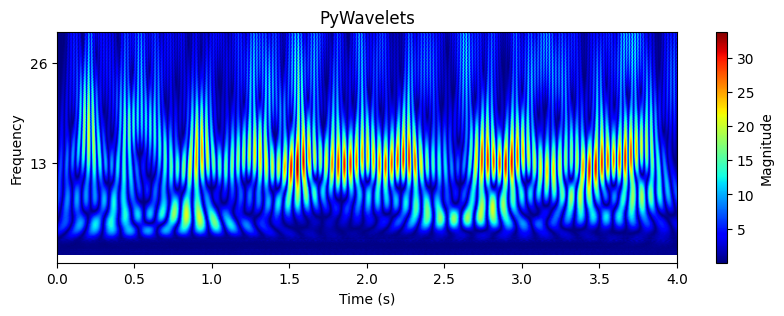

In [5]:
eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",23)
t = np.arange(0, 1000/sampling_rate, 1/sampling_rate)

sampling_rate = 250

filtered_data = signal.lfilter(b, a, eeg_data[61, :, 0, 22])

frequencies = np.arange(1, 40, 0.01) /sampling_rate 
wavelet_name = "morl"
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, frequencies) 
# Transformada Wavelet
cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name) 
# Multiplicamos por samping_rate para recuperar las frecuencias en Hz
frequencies = frequencies*sampling_rate 

plt.figure(figsize=(10, 3))
plt.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(t) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper')
plt.title("PyWavelets")
plt.xlabel("Time (s)")
plt.ylabel("Frequency")
plt.colorbar(label="Magnitude")
plt.ylim(0, 30)
plt.yticks([13, 26])
plt.show()
plt.close()

Comparison filtered vs non-filtered

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_2339/2550728341.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


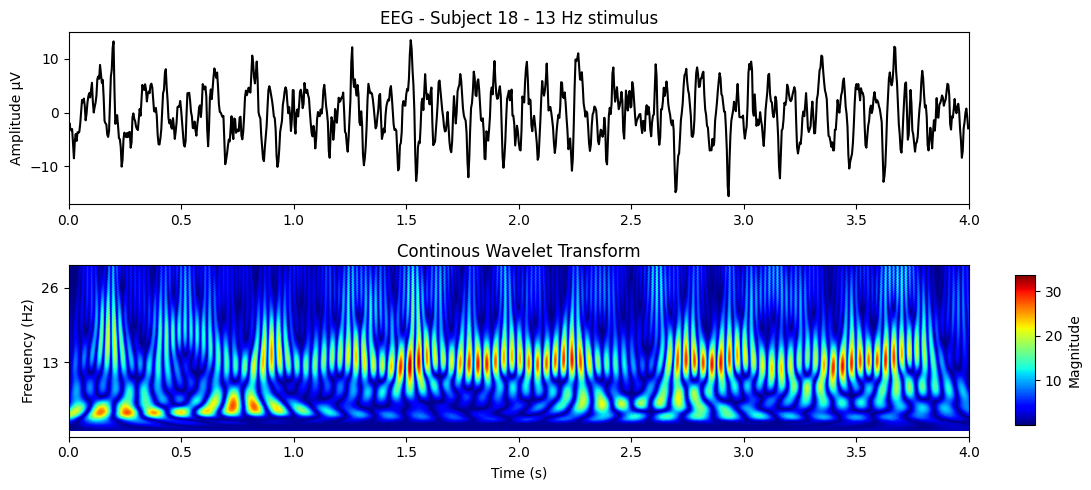

In [136]:
eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",23)
t = np.arange(0, 1000/sampling_rate, 1/sampling_rate)

sampling_rate = 250

filtered_data = signal.lfilter(b, a, eeg_data[61, :, 0, 22])
filtered_data = eeg_data[61, :, 0, 22]

frequencies = np.arange(1, 40, 0.01) /sampling_rate 
wavelet_name = "morl"
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, frequencies) 
# Transformada Wavelet
cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name) 
# Multiplicamos por samping_rate para recuperar las frecuencias en Hz
frequencies = frequencies*sampling_rate 

f_idx = 22
f_value = data_frequencies[f_idx]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5))

ax1.plot(t,filtered_data, 'k')
ax1.set_xlim(0, 4)
ax1.set_ylabel("Amplitude " + '\u03BC' + "V")
ax1.set_title("EEG - Subject 18 - 13 Hz stimulus")

ax2.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(t) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title("Continous Wavelet Transform")
ax2.set_ylim(0, 30)
ax2.set_yticks([13, 26])
cbar_ax2 = fig.add_axes([1.02, 0.14 , 0.02, 0.3])
plt.colorbar(ax2.images[0], cax=cbar_ax2, label="Magnitude")


plt.tight_layout()

## Synthetic Reference Signals

In [15]:
t = np.arange(0, 750/sampling_rate, 1/sampling_rate)

fundamental_frequency = 13
amplitude = 4
n_harmonics = 3

# Generate the base oscillatory signal
oscillatory_signal = amplitude*np.sin(np.pi * 2 * fundamental_frequency * t)

# Generate the frequencies for the harmonics
harmonic_frequencies = [fundamental_frequency * i for i in range(2, 2 + n_harmonics)] 

# Generate signals for the harmonic frequencies
harmonic_signals = [np.sin(np.pi * 2 * f * t) for f in harmonic_frequencies]

for h in range(len(harmonic_signals)):
    harmonic_signals[h] = harmonic_signals[h]*(amplitude/(h+2))

# Combine the original signal with harmonics
#combined_signal = oscillatory_signal + sum(harmonic_signals)

combined_signal = oscillatory_signal

for h in harmonic_signals:
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    
# Add noise
noise_amplitude = 1
noise = noise_amplitude * np.random.randn(len(combined_signal))
noisy_signal = combined_signal + noise


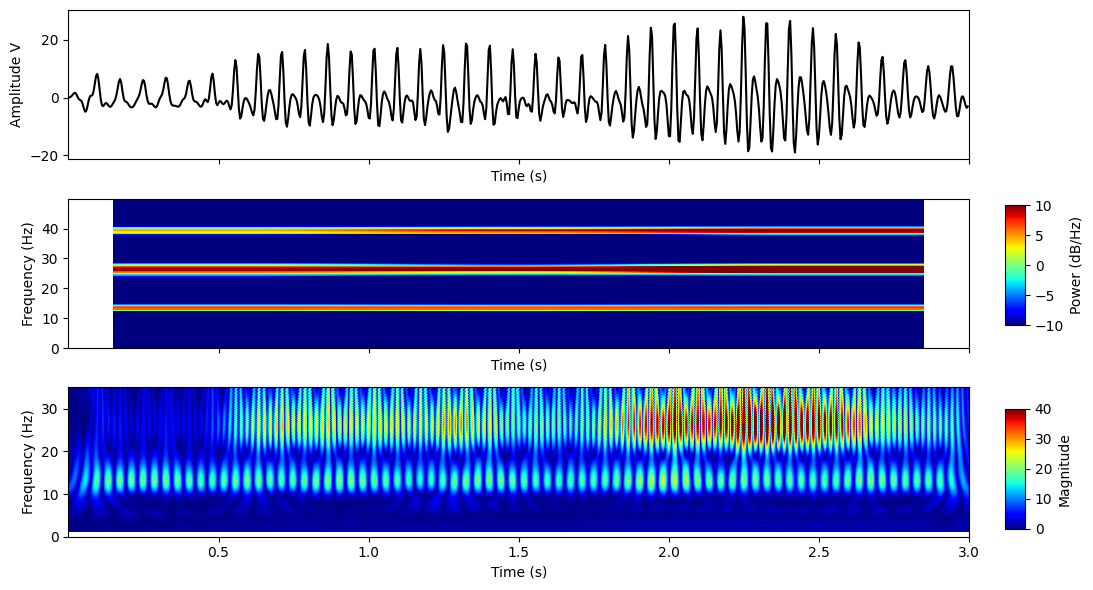

In [16]:
utils.plot_generation_three(noisy_signal, sampling_rate, 0, [10], True, False, "")

In [92]:
t = np.arange(0, 750/sampling_rate, 1/sampling_rate)

fundamental_frequency = 13
amplitude = 4
n_harmonics = 3

freq_chunk1 = 8
freq_chunk2 = 14

noise_amplitude = 0.8
    
# Define time points for frequency changes
change_point1 = int(len(t) / 3)
change_point2 = int(2 * len(t) / 3)

# Generate sine waves with variable frequencies
signal1 = np.sin(2 * np.pi * freq_chunk1 * t[:change_point1])
signal2 = np.sin(2 * np.pi * freq_chunk2 * t[change_point1:change_point2])*1.2
signal3 = np.sin(2 * np.pi * freq_chunk1 * t[change_point2:])
signal4 = np.sin(2 * np.pi * freq_chunk2 * t[change_point2:])*1.2

# Apply cosine window for smooth transitions
window1 = np.hanning(2 * change_point1)[:change_point1]
window2 = np.hanning(change_point2 - change_point1)
window3 = np.hanning(2 * (len(t) - change_point2))[-(len(t) - change_point2):]

# Combine signals with smooth transitions
combined_signal = np.concatenate([signal1 * window1, signal2 * window2, (signal3 + signal4) * window3])
combined_signal = np.concatenate([signal1, signal2, signal3 + signal4]) * 5

# Add noise
noise = noise_amplitude * np.random.normal(size=len(t)) * 4
noisy_signal = combined_signal + noise



/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_33621/246254613.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


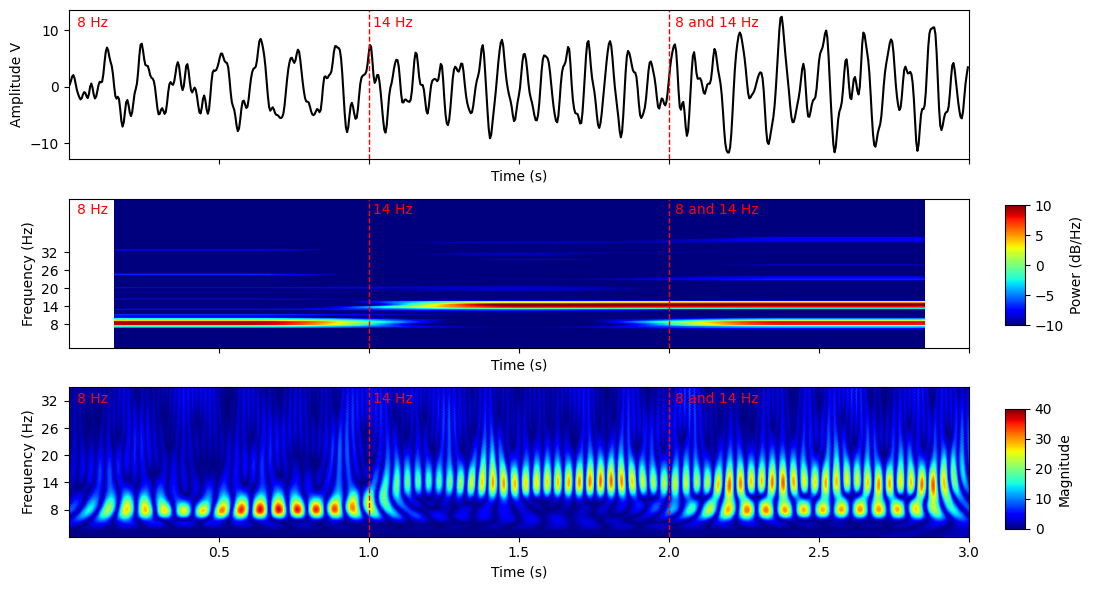

In [95]:
eeg_data = noisy_signal

wavelet_name = "morl" # Morlet

# Filtering
low_freq = 5
high_freq = 40
sampling_rate = 250

b, a = signal.butter(4, [low_freq, high_freq], fs=sampling_rate, btype='band')
filtered_data = signal.lfilter(b, a, eeg_data) 

# Rango de frecuencias a analizar. Hay que dividr por sampling_rate para hacer correctamente el cambio a escala
frequencies = np.arange(1, 40, 0.01) /sampling_rate 
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, frequencies) 
# Transformada Wavelet
cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name) 
# Multiplicamos por samping_rate para recuperar las frecuencias en Hz
frequencies = frequencies*sampling_rate 

t = np.arange(0, len(eeg_data)/sampling_rate, 1/sampling_rate)

# 3 subplots: señal, espectrograma y transformada wavelet
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 6), sharex=True)

ax1.plot(t, filtered_data, 'k')
ax1.set_xlim(0, 4)
if len(eeg_data) < 750:
    ax1.set_xticks([0.5, 1, 1.5, 2, 2.5])
else:
    ax1.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5])
ax1.set_xlim(0, len(eeg_data) / sampling_rate)
ax1.set_ylabel("Amplitude V")
ax1.set_xlabel("Time (s)")

ax1.axvline(x=(change_point1 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk1} Hz')
ax1.axvline(x=(change_point2 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk2} Hz')
ax1.text(0+ 0.08, 10, f'{freq_chunk1} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax1.text((change_point1 / sampling_rate) + 0.08, 10, f'{freq_chunk2} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax1.text((change_point2 / sampling_rate) + 0.16, 10, f'8 and 14 Hz', color='r', va='bottom', ha='center', fontsize=10)

ax2.axvline(x=(change_point1 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk1} Hz')
ax2.axvline(x=(change_point2 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk2} Hz')
ax2.text(0+ 0.08, 44, f'{freq_chunk1} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax2.text((change_point1 / sampling_rate) + 0.08, 44, f'{freq_chunk2} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax2.text((change_point2 / sampling_rate) + 0.16, 44, f'8 and 14 Hz', color='r', va='bottom', ha='center', fontsize=10)

ax3.axvline(x=(change_point1 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk1} Hz')
ax3.axvline(x=(change_point2 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk2} Hz')
ax3.text(0+ 0.08, 31, f'{freq_chunk1} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax3.text((change_point1 / sampling_rate) + 0.08, 31, f'{freq_chunk2} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax3.text((change_point2 / sampling_rate) + 0.16, 31, f'8 and 14 Hz', color='r', va='bottom', ha='center', fontsize=10)


# Valore utilizados para mantener la escala de colores del espectrograma
vmin = -10
vmax = 10

Pxx, freqs, bins, im = ax2.specgram(filtered_data, NFFT=300, Fs=sampling_rate, noverlap=int(300/4), cmap='jet', vmin=vmin, vmax=vmax)
f_value = 2
ticks = [8, 14, 20, 26, 32]
ax2.set_yticks(ticks)
if len(eeg_data) < 750:
    ax2.set_xticks([0.5, 1, 1.5, 2, 2.5])
else:
    ax2.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_ylim(0, 50)
# Add colorbar for the spectrogram
cbar_ax2 = fig.add_axes([1.01, 0.45, 0.02, 0.2])  # [left, bottom, width, height]
plt.colorbar(im, cax=cbar_ax2, label='Power (dB/Hz)')

# Valores utilizados para mantener la escala de colores de la transformada wavelet
vmin = 0 
vmax = 40

ax3.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(filtered_data) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper', vmin=vmin, vmax=vmax)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_ylim(2, 35)
#ticks = np.arange(0, 35, step=f_value)
ax3.set_yticks(ticks)
ax3.set_xlim(0, len(eeg_data) / sampling_rate)  # Adjusted x-axis range
cbar_ax3 = fig.add_axes([1.01, 0.11, 0.02, 0.2])
plt.colorbar(ax3.images[0], cax=cbar_ax3, label="Magnitude")

plt.tight_layout()


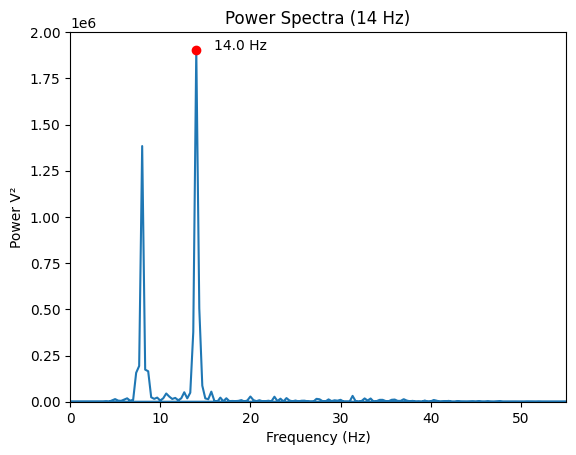

In [96]:
utils.plot_generation_fft(eeg_data, sampling_rate, 14, True, False, "")

## Real EEG recordings

In [2]:
window_length = int(750/3) #We chose 750 because it is the shortest trial duration
window_step = 10 #int(750/24)

print("Window length = ",window_length)
print("Window step = ", window_step)
print("Number of steps = ", len(np.arange(0, 750, step=window_step)), " and ", len(np.arange(0, 1000, step=window_step)))

Window length =  250
Window step =  10
Number of steps =  75  and  100


In [4]:
samples = [180.0, 170.0, 100.0, 190.0, 50.0, 150.0, 150.0, 20.0, 0.0, 150.0, 110.0, 160.0, 140.0, 10.0, 120.0, 30.0, -1.0, 0.0, 60.0, 210.0, 600.0, 590.0, 450.0, 270.0, -1.0, -1.0, 690.0, -1.0, 530.0, -1.0, -1.0, -1.0]
samples_index = 0

sampling_rate = 250
subject = 41
path = "../TFM-GitHub/Dataset BETA/S" + str(subject) +".mat"
data_frequencies, electrodes_names = utils.load_ssvep_additional_info(path)
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",18)

frequencies = [[11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6]]
subjects = [18, 18, 64, 64]
cases = ["best", "worst", "best", "worst"]

data_frequencies[-5] = 15.6

electrode_idx = 61
electrode_name = "OZ"

for i in range(len(subjects)):
    subject = subjects[i]
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)
    case = cases[i]
    for j in range(2):
        index = j+1
        fr_idx = 0
        freq = frequencies[i][j]
        for x in range(40):
            if data_frequencies[x] == freq:
                fr_idx = x
                break
                    
        for tr_idx in range(4):
            path = "../../Universidad/TFM/Imágenes/Results/"
            path += "S"+str(subject)+"_"+electrode_name+"_"+case+"_"+str(index)+"_T"+str(tr_idx)+".png"
            #utils.plot_generation_three(eeg_data[electrode_idx, :, tr_idx, fr_idx], sampling_rate, fr_idx, data_frequencies, False, True, path)
            utils.plot_generation_three(eeg_data[electrode_idx, :, tr_idx, fr_idx], sampling_rate, fr_idx, data_frequencies, False, True, path, shading_sample = int(samples[samples_index]), shading_size = window_length)

            path = "../../Universidad/TFM/Imágenes/Results/"
            path += "S"+str(subject)+"_"+electrode_name+"_"+case+"_"+str(index)+"_T"+str(tr_idx)+"_FFT.png"
            utils.plot_generation_fft(eeg_data[electrode_idx, :, tr_idx, fr_idx], sampling_rate=sampling_rate, frequency=data_frequencies[fr_idx], show_plot=False, save_plot=True, path=path)

            samples_index += 1

0.72 1.72


/Users/tania/Desktop/Tania/Repositorios GitHub/TFM-GitHub/utils.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


0.68 1.68
0.4 1.4
0.76 1.76
0.2 1.2
0.6 1.6
0.6 1.6
0.08 1.08
0.0 1.0
0.6 1.6
0.44 1.44
0.64 1.64
0.56 1.56
0.04 1.04
0.48 1.48
0.12 1.12
0.0 1.0
0.24 1.24
0.84 1.84
2.4 3.4
2.36 3.36
1.8 2.8
1.08 2.08
2.76 3.76
2.12 3.12
